### 데이터 구축

In [ ]:
train_data = []
train_label = []
num = 0

for i in w_list[:-1]:
    tmp = pd.read_csv(i)
    tmp = tmp.replace(" ", np.nan)
    tmp = tmp.interpolate(method = 'values')
    tmp = tmp.fillna(0)
    print(len(tmp))
    for j in tqdm(range(len(tmp)-432)): # 0~26064(26496-432) # 3일치
        train_data.append(np.array(tmp.loc[j:j + 431, ["swl", "inf", "sfw", "ecpc",
                                                       "tototf", "tide_level",
                                                       "fw_1018662", "fw_1018680",
                                                       "fw_1018683", "fw_1019630"]]).astype(float))
        train_label.append(np.array(tmp.loc[j + 432, ["wl_1018662", "wl_1018680",
                                                      "wl_1018683", "wl_1019630"]]).astype(float))

26496


100%|██████████| 26064/26064 [00:15<00:00, 1638.63it/s]


In [ ]:
with open("train_data.pkl","wb") as f:
    pickle.dump(train_data, f)

with open("train_label.pkl","wb") as f:
    pickle.dump(train_label, f)

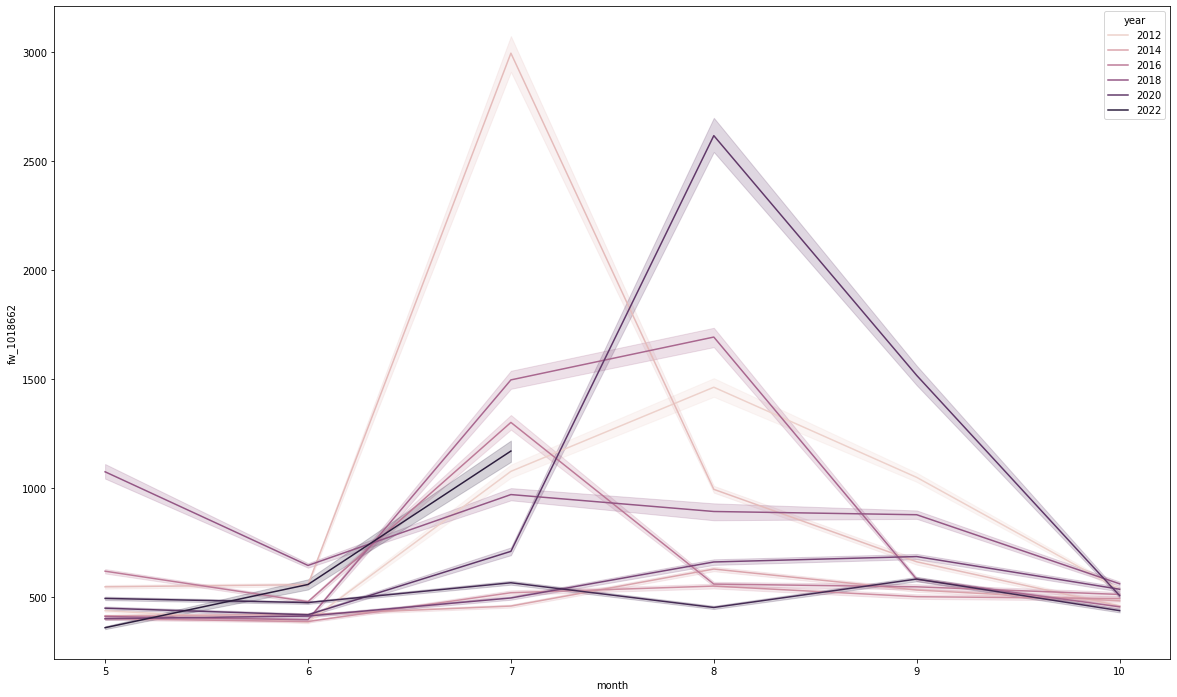

In [ ]:
plt.figure(figsize = (20, 12))
sns.lineplot(x = 'month', y = 'fw_1018662', data = df, hue = 'year')
#plt.xticks(list(range(0, 16*2*12, 15)))
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 데이터 불러오기

In [ ]:
with open("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/train_label.pkl","rb") as f:
    train_label = pickle.load(f)

with open("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/train_data.pkl","rb") as f:
    train_data = pickle.load(f)

In [ ]:
train_data = np.array(train_data)
train_label = np.array(train_label)

print(train_data.shape)
print(train_label.shape)

(260640, 432, 10)
(260640, 4)


### 필요한 라이브러리 불러오기

#### 데이터 개수


- 10년(2012 ~ 2021) * 6개월=184일(5/1~10/31) * 1일(24 * 6) = 264960개

- 1년(2022) * 2개월=79일(5/1~7/18) * 1일(24 * 6) = 11376개

#### Water Data(data_2012.csv)

- ymdhm : 년월일시분
- swl : 팔당댐 현재수위 (단위: El.m)
- inf : 팔당댐 유입량 (단위: m^3/s)
- sfw : 팔당댐 저수량 (단위: 만m^3)
- ecpc : 팔당댐 공용량 (단위: 백만m^3)
- tototf : 총 방류량 (단위: m^3/s)
- tide_level : 강화대교 조위 (단위: cm)
-     
- wl_1018662 : 청담대교 수위 (단위: cm)
- wl_1018680 : 잠수교 수위 (단위: cm)
- wl_1018683 : 한강대교 수위 (단위: cm)
- wl_1019630 : 행주대교 수위 (단위: cm)
- 
- fw_1018662 : 청담대교 유량 (단위: m^3/s)
- fw_1018680 : 잠수교 유량 (단위: m^3/s)
- fw_1018683 : 한강대교 유량 (단위: m^3/s)    
- fw_1019630 : 행주대교 유량 (단위: m^3/s)

    
#### RainFall Data(rf_2012.csv)

- YMDHM : 년월일시분
- rf_10184100 : 대곡교 강수량
- rf_10184110 : 진관교 강수량
- rf_10184140 : 송정동 강수량

### pytoch

In [ ]:
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.23.2 --user

In [ ]:
import sklearn
sklearn.__version__

In [ ]:
!pip install pycaret[full]

In [ ]:
from pycaret.utils import enable_colab
enable_colab()

In [ ]:
!pip install markupsafe==2.0.1

In [ ]:
import jinja2
from pycaret.regression import *

### import

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

import os
from glob import glob
from tqdm import tqdm
from scipy import interpolate
import pickle


import datetime as dt
import joblib
import time

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from itertools import permutations, combinations

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, AveragePooling1D, GlobalAveragePooling1D

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, plot_tree, plot_importance
from lightgbm import LGBMRegressor
#from catboost import CatBoostClassifier, Pool, CatBoostRegressor

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostRegressor,  HistGradientBoostingRegressor, StackingRegressor, RandomForestRegressor

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor

#import optuna 
#from optuna import Trial, visualization
#from optuna.samplers import TPESampler

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action='ignore')

#GPU 자원이 부족한 경우 아래 코드를 이용하세요
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## water_rf_data(water_data + rf_data) 제작
#w_list = sorted(glob("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_data/*.csv"))
#r_list = sorted(glob("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/rf_data/*.csv"))
#for i in list(range(2012, 2023)):
#  globals()['w{0}'.format(i)] = pd.read_csv(w_list[i-2012])
#  globals()['r{0}'.format(i)] = pd.read_csv(r_list[i-2012])
#  globals()['wr{0}'.format(i)] = pd.concat([globals()['w{0}'.format(i)], globals()['r{0}'.format(i)]],axis=1) # 두 데이터프레임 결합
#for i in list(range(2012, 2023)):
#  globals()['wr{0}'.format(i)].to_csv('wr{0}.csv'.format(i), index = False)

wr_list = sorted(glob("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/*.csv")) # 2012~2021 + 2022-05-01 00:00 ~ 2022-07-18 23:50 
sample_submission = pd.read_csv("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/sample_submission.csv") # 2022-06-01 00:00	~ 2022-07-18 23:50	6912개
wr_list

['./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2012.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2013.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2014.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2015.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2016.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2017.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2018.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2019.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2020.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2021.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2022.csv']

In [48]:
# 전체 데이터프레임 결합(2012~2021년)
df_list = []
for i in wr_list:
    df_list.append(pd.read_csv(i))

df = pd.concat(df_list, ignore_index=True)
df = df.drop(['ymdhm.1'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276336 entries, 0 to 276335
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ymdhm        276336 non-null  object 
 1   swl          275593 non-null  float64
 2   inf          275593 non-null  float64
 3   sfw          275593 non-null  float64
 4   ecpc         275593 non-null  float64
 5   tototf       275593 non-null  float64
 6   tide_level   271409 non-null  float64
 7   wl_1018662   276277 non-null  float64
 8   fw_1018662   259956 non-null  float64
 9   wl_1018680   276277 non-null  float64
 10  fw_1018680   79487 non-null   float64
 11  wl_1018683   276277 non-null  float64
 12  fw_1018683   275057 non-null  float64
 13  wl_1019630   276277 non-null  float64
 14  fw_1019630   276277 non-null  float64
 15  rf_10184100  276336 non-null  float64
 16  rf_10184110  276336 non-null  float64
 17  rf_10184140  276336 non-null  float64
dtypes: float64(17), object(1

### 데이터 전처리

In [49]:
def date_conv(df):
    df['ymdhm'] = pd.to_datetime(df['ymdhm'])
    df['year'] = df['ymdhm'].dt.year
    df['month'] =df['ymdhm'].dt.month
    df['day'] =df['ymdhm'].dt.day
    df['weekday'] = df['ymdhm'].dt.weekday
    df = df.drop('ymdhm', axis=1)
    return df

df = date_conv(df)
df.shape

(276336, 21)

### 데이터 결측치

In [50]:
df = df.fillna(df.mean())


### train, val, test 데이터셋 만들기

In [55]:
Y = df[["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]]
X = df.drop(columns=["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"], axis=1)
17856
X_train = X.iloc[:251712, :]
y_train = Y.iloc[:251712, :]

X_val = X.iloc[251712:269424, :]
y_val = Y.iloc[251712:269424, :]

X_test = X.iloc[269424:, :]
y_test = Y.iloc[269424:, :]
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(251712, 17) (251712, 4) (17712, 17) (17712, 4) (6912, 17) (6912, 4)


In [56]:
X_val

,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,rf_10184100,rf_10184110,rf_10184140,year,month,day,weekday
251712,25.06,36.00,213.59,30.41,137.00,513.0,280.22,0.0,277.43,406.79,0.0,0.0,0.0,2021,8,1,6
251713,25.05,0.00,213.23,30.77,150.00,502.0,285.72,0.0,260.87,406.79,0.0,0.0,0.0,2021,8,1,6
251714,25.05,0.00,213.23,30.77,162.00,491.0,285.72,0.0,248.45,406.79,0.0,0.0,0.0,2021,8,1,6
251715,25.05,0.00,213.23,30.77,162.00,480.0,280.22,0.0,285.71,438.33,0.0,0.0,0.0,2021,8,1,6
251716,25.05,61.00,213.23,30.77,162.00,467.0,280.22,0.0,302.28,493.58,0.0,0.0,0.0,2021,8,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269419,25.18,140.94,217.99,26.01,140.94,220.0,285.72,0.0,575.57,493.58,0.0,0.0,0.0,2022,5,31,1
269420,25.18,141.07,217.99,26.01,141.07,208.0,274.78,0.0,501.04,505.03,0.0,0.0,0.0,2022,5,31,1
269421,25.18,141.01,217.99,26.01,141.01,196.0,269.40,0.0,425.89,505.03,0.0,0.0,0.0,2022,5,31,1
269422,25.19,755.75,218.36,25.64,140.75,184.0,264.07,0.0,198.19,493.58,0.0,0.0,0.0,2022,5,31,1


### model

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=2, shuffle=True)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

params = {
    "n_estimators" : (100, 150, 200)
}

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_cv = GridSearchCV(rf,
                       param_grid=params,
                       cv = kfold,
                       n_jobs=-1)

### 모델링 및 모델 학습

In [ ]:
import gc
gc.collect()

88

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#from tensorflow.keras import layers
#from tensorflow.keras import layers as L

input_shape = (train_data[0].shape[0], train_data[0].shape[1])

# https://buomsoo-kim.github.io/keras/2019/08/02/Easy-deep-learning-with-Keras-22.md/ : CuDNN을 활용한 GRU


model = Sequential()
model.add(GRU(256, return_sequences = True, input_shape=input_shape))
model.add(GRU(128, return_sequences = False)) 
model.add(Dense(4, activation = 'relu'))

#inputs = L.Input(shape = (data_for_scaler.shape[1], data_for_scaler.shape[2]))
#gru1 = L.GRU(256, return_sequences = True, dropout = 0.2)(inputs)
#ap = L.AveragePooling1D()(gru1)
#gru2 = L.GRU(150, return_sequences = True)(ap)
#GAP = L.GlobalAveragePooling1D()(gru2)
#dense = L.Dense(61, activation = "softmax")(GAP)

#optimizer = tf.optimizers.RMSprop(0.001)
optimizer = tf.optimizers.Adam(0.001)
#optimizer = tf.optimizers.AdamW(0.001)


model.compile(optimizer=optimizer,loss='mse', metrics=['mae'])

In [ ]:
def cudnn_gru_model():
    model = Sequential()
    model.add(CuDNNGRU(50, input_shape = (300,1), return_sequences = True))
    model.add(CuDNNGRU(1, return_sequences = False))
    model.add(Activation('sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [ ]:
model.fit(train_data, train_label, epochs=10, batch_size=128)

Epoch 1/10
2037/2037 [==============================] - 154s 72ms/step - loss: 46245.2617 - mae: 195.2990
Epoch 2/10
2037/2037 [==============================] - 150s 74ms/step - loss: 6935.7695 - mae: 52.7049
Epoch 3/10
2037/2037 [==============================] - 150s 74ms/step - loss: 3313.0037 - mae: 26.5996
Epoch 4/10
2037/2037 [==============================] - 150s 74ms/step - loss: 1470.4374 - mae: 11.2595
Epoch 5/10
2037/2037 [==============================] - 150s 73ms/step - loss: 774.6173 - mae: 8.8993
Epoch 6/10
2037/2037 [==============================] - 150s 73ms/step - loss: 510.9503 - mae: 8.7359
Epoch 7/10
2037/2037 [==============================] - 149s 73ms/step - loss: 411.4238 - mae: 8.8388
Epoch 8/10
2037/2037 [==============================] - 149s 73ms/step - loss: 368.9583 - mae: 8.5363
Epoch 9/10
2037/2037 [==============================] - 149s 73ms/step - loss: 303.2803 - mae: 8.5472
Epoch 10/10
2037/2037 [==============================] - 148s 72ms/step 

### 추론 데이터셋 만들기

In [ ]:
test_data = []
test_label = []

tmp = pd.read_csv(w_list[-1])
tmp = tmp.replace(" ", np.nan)
# 이전값을 사용
tmp = tmp.fillna(method = 'pad')
tmp = tmp.fillna(0)
    
#tmp.loc[:, ["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]] = tmp.loc[:, ["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]]*100
    
for j in tqdm(range(4032, len(tmp)-432)):
    test_data.append(np.array(tmp.loc[j:j + 431, ["swl", "inf", "sfw", "ecpc",
                                                    "tototf", "tide_level",
                                                    "fw_1018662", "fw_1018680",
                                                    "fw_1018683", "fw_1019630"]]).astype(float))
        
    test_label.append(np.array(tmp.loc[j + 432, ["wl_1018662", "wl_1018680",
                                                    "wl_1018683", "wl_1019630"]]).astype(float))

100%|██████████| 6912/6912 [00:07<00:00, 978.91it/s]


In [ ]:
test_data = np.array(test_data)
test_label = np.array(test_label)

print(test_data.shape)
print(test_label.shape)

(6912, 432, 10)
(6912, 4)


### 제출 파일 만들기

In [ ]:
pred = model.predict(test_data)

In [ ]:
pred = pd.DataFrame(pred)

In [ ]:
sample_submission = pd.read_csv("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/sample_submission.csv")

sample_submission["wl_1018662"] = pred[0]
sample_submission["wl_1018680"] = pred[1]
sample_submission["wl_1018683"] = pred[2]
sample_submission["wl_1019630"] = pred[3]

In [ ]:
sample_submission.to_csv("baseline.csv", index = False)